グラフ

ノード: 各通貨（USD, EUR, JPY）や経済指標（GDP, インフレ率、失業率）をノードとする。

エッジ: 通貨間（為替レートの相関性や取引量）や通貨と経済指標間の関係性を初期的な隣接行列 𝐴として設定。
- 初期値は事前知識や過去データ（例えば、相関係数）を用いる。
- A は固定せず、GATが学習を通じてエッジ重みを動的に調整。

ノード特徴量

通貨ノード: 現在の価格変動率、移動平均、出来高、ボラティリティなど。

経済指標ノード: 最新のGDP成長率、CPI、金利、貿易収支など。

## Data Preparation

### FX

In [1]:
import glob
files = []
symbols = ["EURUSD", "USDJPY", "EURJPY"]

for symbol in symbols:
    files.extend(glob.glob(f'L:/data/fx/HistData/csv/{symbol}*.csv'))

In [ ]:
# multi_index = pd.MultiIndex.from_product(
#     [symbols, ['open', 'high', 'low', 'close', 'volume']],
#     names=["symbol", "attribute"])
# df.columns = multi_index
# df.head()

In [ ]:
files

In [2]:
import pandas as pd

df = None

for file in files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, names=["open", "high", "low", "close", "volume"], header=0)
    temp_df = temp_df[~temp_df.index.duplicated(keep='first')]
    resampler = temp_df["close"].resample("1D")
    close_srs = resampler.last()

    if df is None:
        df = close_srs
    else:
        df = pd.concat([df, close_srs], axis=1).dropna()

del temp_df, close_srs, resampler

In [47]:
def get_ratio_df(df, symbols, period):
    rev_symbols = [symbol[3:] + symbol[:3] for symbol in symbols]
    ratio_df = df.iloc[period:] / df.iloc[:-period].values
    reverse_ratio_df = (1/df).iloc[period:] / (1/df).iloc[:-period].values
    reverse_ratio_df.columns = rev_symbols
    ratio_df = pd.concat([ratio_df, reverse_ratio_df], axis=1)
    return ratio_df

def approx_min_max(df, max_q, min_q):
    # to reduce an impact of outflier
    apx_max = df.quantile(max_q)
    apx_min = df.quantile(min_q)
    # apply min max
    token_df = (df - apx_min) / (apx_max - apx_min)
    return token_df, apx_max, apx_min

def make_multi_index(df, column):
    symbols = df.columns
    multi_index = pd.MultiIndex.from_product([symbols, [column]], names=["symbol", "attribute"])
    df.columns = multi_index
    return df

In [ ]:
features = []
periods = [1, 5]
q = [0.9999, 0.999]
token_params = []

for index, period in enumerate(periods):
    token_df = get_ratio_df(df, symbols, period)
    token_df, apx_max, apx_min = approx_min_max(token_df, q[index], 0)
    token_df = make_multi_index(token_df, f"ratio_{period}")
    features.append(token_df)
    token_param = pd.concat([apx_min, apx_max], axis=1, keys=[(f"ratio_{period}", "min"), (f"ratio_{period}", "max")])
    token_params.append(token_param)

symbol_features = pd.concat(features, axis=1).dropna()
token_params = pd.concat(token_params, axis=1)
symbol_features.head()

In [60]:
symbol_features.to_csv("./symbol_features_token.csv")
token_params.to_csv("./symbol_feature_token_params.csv")

#### Revert applied transformations

In [75]:
symbol_features = pd.read_csv("symbol_features_token.csv", header=[0, 1], index_col=0)
token_params = pd.read_csv("./symbol_feature_token_params.csv", header=[0, 1], index_col=0)

In [ ]:
symbol_features.columns = symbol_features.columns.swaplevel(0, 1)
period = 1

token_df = symbol_features[f"ratio_{period}"]
token_param = token_params[f"ratio_{period}"]

In [ ]:
observation_length = 10
symbol = "USDJPY"

# start index to test
index = 300
apx_min = token_param.loc[symbol, "min"]
apx_max = token_param.loc[symbol, "max"]

output = token_df[symbol].iloc[index+observation_length]
denominator_index = token_df.iloc[index+observation_length-period].name\

reverted_value = (output * (apx_max - apx_min) + apx_min) * df.loc[denominator_index, symbol]

answer_index = token_df.iloc[index+observation_length].name
answer_value = df.loc[answer_index, symbol]

print(reverted_value, answer_value)

### Commodity

In [ ]:
commodity_symbols = ["oil", "gold"]
commodity_files = []
for symbol in commodity_symbols:
    commodity_files.extend(glob.glob(f'L:/data/stocknet/indicators/*{symbol}*.csv'))
commodity_files

In [ ]:
com_df = pd.read_csv(commodity_files[0],index_col=0, parse_dates=True, names=["close", "open", "high", "low", "volume", "pct"], header=0)
com_df.head()

In [20]:
import pandas as pd

com_df = None

for file in commodity_files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, names=["close", "open", "high", "low", "volume", "pct"], header=0)
    close_srs = temp_df["close"]
    if close_srs.dtype == pd.StringDtype:
        close_srs = close_srs.str.replace(",", "").astype(float)

    if com_df is None:
        com_df = close_srs
    else:
        com_df = pd.concat([com_df, close_srs], axis=1).dropna()

com_df.columns = commodity_symbols
del temp_df, close_srs

In [ ]:
pct_df = com_df.pct_change()
_ = pct_df.hist(bins=1000)

In [ ]:
com_df = pd.concat([df, com_df], axis=1).dropna()
com_df.head()

In [ ]:
EUR_com_df = com_df[commodity_symbols].mul((1/com_df["EURUSD"]), axis=0)
EUR_com_df.head()

In [ ]:
JPY_com_df = com_df[commodity_symbols].mul((com_df["USDJPY"]), axis=0)
JPY_com_df.head()

In [ ]:
com_df = com_df[commodity_symbols]
com_df = pd.concat([com_df, EUR_com_df, JPY_com_df], axis=1)
multi_index = pd.MultiIndex.from_product(
    [["USD", "EUR", "JPY"], commodity_symbols],
    names=["symbol", "attribute"])
com_df.columns = multi_index
com_df.head()

In [26]:
com_df.to_csv("./commodity_features.csv")

In [ ]:
com_token_df = com_df.pct_change().dropna()
com_token_df.columns = com_token_df.columns.swaplevel(0, 1)
com_stat_df = com_token_df.describe()
com_stat_df

In [ ]:
apprx_min_oil = com_token_df["oil"].quantile(0.005)
min_oil = com_stat_df["oil"].loc["min"]
apprx_max_oil = com_token_df["oil"].quantile(0.995)
max_oil = com_stat_df["oil"].loc["max"]

oil_token_df = (com_token_df["oil"] - apprx_min_oil) / (apprx_max_oil - apprx_min_oil)
oil_token_df.head()

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, column in enumerate(oil_token_df.columns):
    axs[i].hist(oil_token_df[column], bins=1000)
    axs[i].set_xlim(-0.5, 1.5)
fig.show()

In [ ]:
max_gold = com_stat_df["gold"].loc["max"]
apprx_max_gold = com_token_df["gold"].quantile(0.99)
apprx_min_gold = com_token_df["gold"].quantile(0.01)

gold_token_df = (com_token_df["gold"] - apprx_min_gold) / (apprx_max_gold - apprx_min_gold)
gold_token_df.head()

In [ ]:
_ = gold_token_df.hist(bins=1000)

In [ ]:
com_token_df = pd.concat([oil_token_df, gold_token_df], axis=1)
multi_index = pd.MultiIndex.from_product(
    [commodity_symbols, ["USD", "EUR", "JPY"]],
    names=["attribute", "symbol"])
com_token_df.columns = multi_index.swaplevel(0, 1)
com_token_df = com_token_df[["USD", "EUR", "JPY"]]
com_token_df.head()

In [33]:
com_token_df.to_csv("./commodity_features_token.csv")

In [ ]:
additional_feature_symbol_dict = {
    "USD": ["US-10-year-bond-yield", "NY_daw"],
    "EUR": ["germany-10-year-bond",  "dax_price"],
    "JPY": ["japan-10-year-bond", "japan-ni225"]
}
additional_feature_symbols = ["bond", "stock"]
additional_feature_files = []

for symbol_key_list in additional_feature_symbol_dict.values():
    for symbol_key in symbol_key_list:
         additional_feature_files.extend(glob.glob(f'L:/data/stocknet/indicators/*{symbol_key}*.csv'))
additional_feature_files

In [35]:
import pandas as pd

feature_df = None

for file in additional_feature_files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, header=0)
    if len(temp_df.columns) == 5:
        temp_df.columns = ["close", "open", "high", "low", "pct"]
    else:
        temp_df.columns = ["close", "open", "high", "low", "volume", "pct"]
    temp_df = temp_df[~temp_df.index.duplicated(keep='first')]
    close_srs = temp_df["close"]
    if close_srs.dtype == pd.StringDtype:
        close_srs = close_srs.str.replace(",", "").astype(float)

    if feature_df is None:
        feature_df = close_srs
    else:
        feature_df = pd.concat([feature_df, close_srs], axis=1).dropna()

multi_index = pd.MultiIndex.from_product(
    [["USD", "EUR", "JPY"], additional_feature_symbols],
    names=["symbol", "attribute"])
feature_df.columns = multi_index
feature_df.index.name = "date"
del temp_df, close_srs

In [ ]:
feature_df.head()

In [ ]:
pct_df = feature_df.pct_change().dropna()
pct_df.plot()

In [ ]:
feature_df[feature_df == 0].dropna(how="all")

In [ ]:
feature_df.columns = feature_df.columns.swaplevel(0,1)
stock_token_df = feature_df["stock"].pct_change().dropna()
stock_token_df.head()

In [ ]:
stock_token_stat = stock_token_df.describe()
stock_token_stat

In [ ]:
apprx_min_stock = stock_token_df.quantile(0.001)
min_stock = stock_token_stat.loc["min"]
apprx_max_stock = stock_token_df.quantile(0.995)
max_stock = stock_token_stat.loc["max"]

stock_token_std_df = (stock_token_df - apprx_min_stock) / (apprx_max_stock - apprx_min_stock)
stock_token_std_df.head()

In [ ]:
_ = stock_token_std_df.hist(bins=1000)

In [43]:
stock_token_std_df.to_csv("stock_pct_token.csv")

In [44]:
bond_diff_uj = feature_df["bond"]["USD"] - feature_df["bond"]["JPY"]
bond_diff_ue = feature_df["bond"]["USD"] - feature_df["bond"]["EUR"]
bond_diff_ej = feature_df["bond"]["EUR"] - feature_df["bond"]["JPY"]

In [ ]:
bond_symbol_diff_df = pd.concat([bond_diff_uj, bond_diff_ue, bond_diff_ej], keys=["UJ", "UE", "EJ"], axis=1)
bond_symbol_diff_df.plot()

In [ ]:
bond_symbol_diff_token_df = ((bond_symbol_diff_df +1)/6)
_ = bond_symbol_diff_token_df.hist(bins=1000)

In [47]:
bond_symbol_diff_token_df.to_csv("./bond_symbol_diff_token.csv")

In [ ]:
bond_diff_df = feature_df["bond"].diff().dropna()
bond_diff_df.plot()

In [ ]:
bond_diff_stat = bond_diff_df.describe()
bond_diff_stat

In [ ]:
apprx_min_bond = bond_diff_df.quantile(0.001)
min_bond = bond_diff_stat.loc["min"]
apprx_max_bond = bond_diff_df.quantile(0.995)
max_bond = bond_diff_stat.loc["max"]

bond_token_std_df = (bond_diff_df - apprx_min_bond) / (apprx_max_bond - apprx_min_bond)
bond_token_std_df.head()

In [ ]:
_ = bond_token_std_df.hist(bins=1000)

In [52]:
bond_token_std_df.to_csv("./bond_diff_token.csv")

## Feature Vector

In [86]:
import pandas as pd

symbol_df = pd.read_csv("symbol_features_token.csv", header=[0, 1], index_col=0)
com_df = pd.read_csv("commodity_features_token.csv", header=[0, 1], index_col=0)
bond_df = pd.read_csv("bond_diff_token.csv", header=0, index_col=0)
bond_sdiff_df = pd.read_csv("bond_symbol_diff_token.csv", header=0, index_col=0)
stock_df = pd.read_csv("stock_pct_token.csv", header=0, index_col=0)

In [87]:

import re

tokens = {
    "currency": symbol_df,
    # "commodity": com_df,
    # "bond": bond_df,
    # "stock": stock_df
}
token_columns = {}
symbols = ["USD", "EUR", "JPY"]

for symbol in symbols:
    pattern = rf"{symbol}.*"
    token_columns[symbol] = {}
    for key, df in tokens.items():
        symbol_columns = []
        for columns in df.columns:
            if isinstance(columns, tuple):
                # columns = (symbol, attribute)
                match = re.match(pattern, columns[0])
            else:
                # columns = symbol
                match = re.match(pattern, columns)
            if match:
                symbol_columns.append(columns)

        token_columns[symbol][key] = symbol_columns

In [88]:
feature_df = None

for symbol in symbols:
    symbol_feature_df = None
    for key, columns in token_columns[symbol].items():
        df = tokens[key][columns]
        if len(columns) == 1 and columns[0] == symbol:
            df.columns = [key]
        else:
            columns = ["_".join(column) for column in columns]
            df.columns = columns
        if symbol_feature_df is None:
            symbol_feature_df = df
        else:
            symbol_feature_df = pd.concat([symbol_feature_df, df], axis=1).dropna()
    multi_index = pd.MultiIndex.from_product([[symbol], symbol_feature_df.columns], names=["symbol", "attribute"])
    symbol_feature_df.columns = multi_index
    if feature_df is None:
        feature_df = symbol_feature_df
    else:
        feature_df = pd.concat([feature_df, symbol_feature_df], axis=1)

In [ ]:
feature_df.head()

## Model Definition and Test it

For each observation X_t, calculate attention weight. Use it as adjacency matrix.
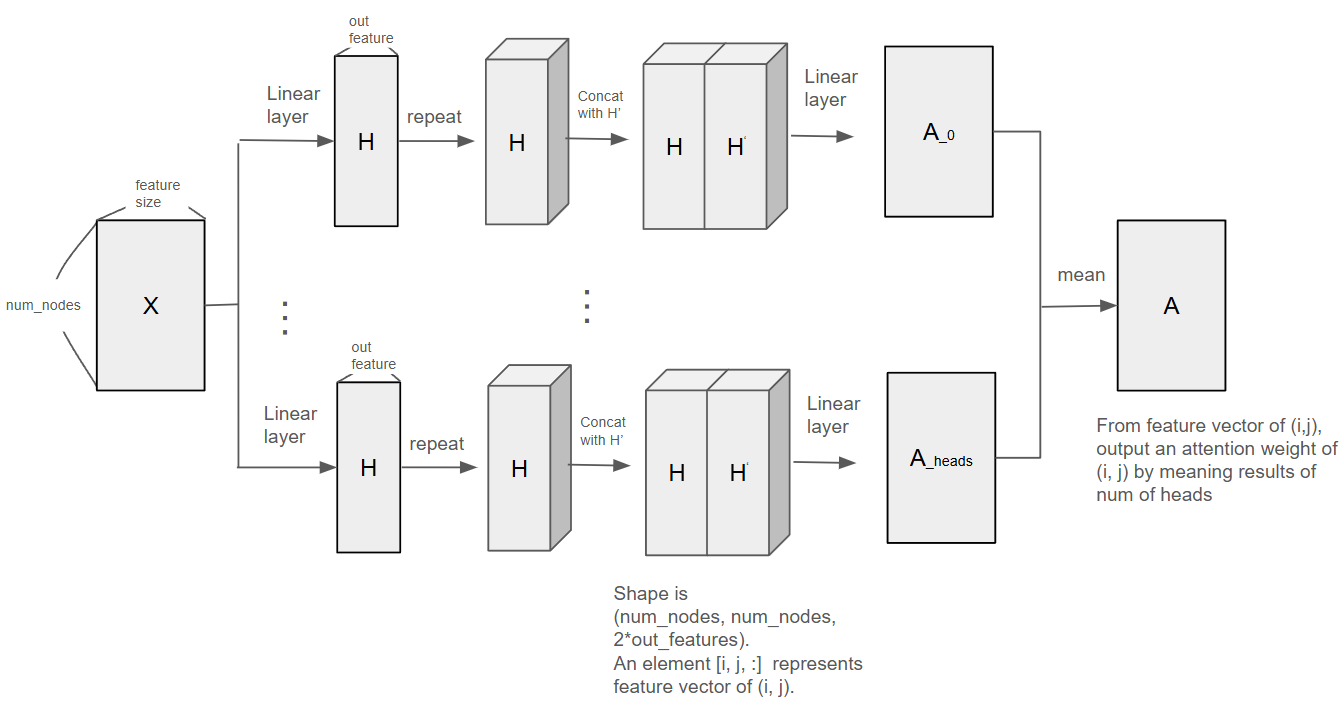

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesGAT(nn.Module):
    def __init__(self, in_features, out_features, num_heads):
        super(TimeSeriesGAT, self).__init__()
        self.gat_layers = nn.ModuleList([
            nn.Linear(in_features, out_features) for _ in range(num_heads)
        ])
        self.attention_layers = nn.ModuleList([
            nn.Linear(2 * out_features, 1) for _ in range(num_heads)
        ])
        self.num_heads = num_heads

    def forward(self, X):
        # X shape: (num_nodes, length, in_features)
        num_nodes, length, in_features = X.shape
        adjacency_matrices = []  # To store A_t for each timestep
        
        for t in range(length):  # Process each time slice
            X_t = X[:, t, :]  # Shape: (num_nodes, in_features)
            head_adjacencies = []

            for head in range(self.num_heads):
                H = self.gat_layers[head](X_t)  # Shape: (num_nodes, out_features)
                H_repeat = H.unsqueeze(0).repeat(num_nodes, 1, 1)  # Shape: (num_nodes, num_nodes, out_features)
                H_concat = torch.cat([H_repeat, H_repeat.transpose(0, 1)], dim=-1)  # Shape: (num_nodes, num_nodes, 2*out_features)
                attention = F.leaky_relu(self.attention_layers[head](H_concat))  # Shape: (num_nodes, num_nodes, 1)
                attention = F.softmax(attention, dim=1).squeeze(-1)  # Shape: (num_nodes, num_nodes)
                head_adjacencies.append(attention)

            # Combine attention heads into a single adjacency matrix
            A_t = torch.mean(torch.stack(head_adjacencies, dim=0), dim=0)  # Shape: (num_nodes, num_nodes)
            adjacency_matrices.append(A_t)

        return torch.stack(adjacency_matrices, dim=0)  # Shape: (length, num_nodes, num_nodes)

In [90]:
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_features, embedding_dim):
        super(TimeSeriesGNN, self).__init__()
        self.linear = nn.Linear(in_features, embedding_dim)

    def forward(self, A, X):
        # A shape: (length, num_nodes, num_nodes)
        # X shape: (length, num_nodes, in_features)
        length, num_nodes, _ = A.shape
        embeddings = []

        for t in range(length):
            A_t = A[t]  # Shape: (num_nodes, num_nodes)
            X_t = X[t]  # Shape: (num_nodes, in_features)
            H_t = F.relu(A_t @ self.linear(X_t))  # Shape: (num_nodes, embedding_dim)
            embeddings.append(H_t)

        return torch.stack(embeddings, dim=0)  # Shape: (length, num_nodes, embedding_dim)


In [91]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(TimeSeriesPredictor, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, H):
        # H shape: (length, num_nodes, embedding_dim)
        length, num_nodes, embedding_dim = H.shape
        H_flat = H.permute(1, 0, 2)  # Shape: (num_nodes, length, embedding_dim)
        lstm_out, _ = self.lstm(H_flat)  # Shape: (num_nodes, length, hidden_dim)
        predictions = self.fc(lstm_out)  # Shape: (num_nodes, length, output_dim)
        return predictions.permute(1, 0, 2)  # Shape: (length, num_nodes, output_dim)

In [92]:
class TimeGraphModel(nn.Module):
    def __init__(self, in_features, out_features, num_heads, embedding_dim, hidden_dim, output_dim):
        super(TimeGraphModel, self).__init__()
        self.gat = TimeSeriesGAT(in_features, out_features, num_heads)
        self.gnn = TimeSeriesGNN(in_features, embedding_dim)
        self.predictor = TimeSeriesPredictor(embedding_dim, hidden_dim, output_dim)

    def forward(self, X):
        # X shape: (num_nodes, length, in_features)
        A = self.gat(X)  # Shape: (length, num_nodes, num_nodes)
        H = self.gnn(A, X.permute(1, 0, 2))  # Shape: (length, num_nodes, embedding_dim)
        predictions = self.predictor(H)  # Shape: (length, num_nodes, output_dim)   
        return predictions

In [ ]:
# sample observation
feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbol].values.tolist() for symbol in symbols]
X_t = torch.tensor(X_t)

In [ ]:
num_nodes, _, feature_dim = X_t.shape

model = TimeGraphModel(in_features=feature_dim, out_features=2, embedding_dim=4, num_heads=4, hidden_dim=5, output_dim=1)
y = model(X_t)
y.shape

In [94]:
import random
from collections.abc import Iterable

import numpy as np
import torch
from torch.utils.data import Dataset

class FeatureDataset(Dataset):

    def __init__(
        self,
        df,
        symbols: list,
        observation_length,
        device="cuda",
        seed=1017,
        is_training=True,
        randomize=True,
        split_ratio=0.9,
        dtype=torch.float,
        batch_size = None
    ):
        self.seed(seed)
        self.data = df
        self.dtype = dtype
        self.is_training = is_training
        self.device = device
        self._columns = symbols
        self.observation_length = observation_length
        self._split_ratio = split_ratio
        self.batch_size = batch_size
        self._init_indicies(randomize)

    def _init_indicies(self, randomize=True):
        train_data_length = int(len(self.data.index) * self._split_ratio)
        train_indices = list(range(self.observation_length, train_data_length))
        eval_indices = list(range(train_data_length + self.observation_length, len(self.data.index)))
        if randomize:
            train_indices = random.sample(train_indices, k=len(train_indices))
            eval_indices = random.sample(eval_indices, k=len(eval_indices))
        self.train_indices, self.eval_indices = train_indices, eval_indices

        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def output_indices(self, index):
        # return slice(index - self.observation_length + 1, index + 1)
        return index

    def _output_func(self, batch_size):
        indices = self._indices[batch_size]
        if type(indices) == int:
            ndx = self.output_indices(indices)
            feature_y = self.data.iloc[ndx]
            y = [feature_y[symbol].values.tolist() for symbol in self._columns]
            ans = torch.tensor(y, device=self.device, dtype=self.dtype)
            return ans
        else:
            chunk_data = []
            for index in indices:
                ndx = self.output_indices(index)
                feature_y = self.data.iloc[ndx]
                y = [feature_y[symbol].values.tolist() for symbol in self._columns]
                chunk_data.append(y)
            ans = torch.tensor(chunk_data, device=self.device, dtype=self.dtype)
            return ans

    def input_indices(self, index):
        return slice(index - self.observation_length, index)

    def _input_func(self, batch_size):
        indices = self._indices[batch_size]
        if type(indices) == int:
            ndx = self.input_indices(indices)
            feature_x = self.data.iloc[ndx]
            x = [feature_x[symbol].values.tolist() for symbol in self._columns]
            src = torch.tensor(x, device=self.device, dtype=self.dtype)
            return src
        else:
            chunk_src = []
            for index in indices:
                ndx = self.input_indices(index)
                feature_x = self.data.iloc[ndx]
                x = [feature_x[symbol].values.tolist() for symbol in self._columns]
                chunk_src.append(x)

            src = torch.tensor(chunk_src, device=self.device, dtype=self.dtype)
            return src

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def __iter__(self):
        self._init_indicies()
        self._index = 0
        if self.batch_size is None or self.batch_size == 1:
            self.batch_size = 1
            self._get_itr_ndx = lambda i: i
        else:
            self._get_itr_ndx = lambda i: slice(i, i + self.batch_size)
        return self
 
    def __next__(self):
        if self._index + self.batch_size >= len(self):
            raise StopIteration
        ndx = self._get_itr_ndx(self._index)
        self._index += self.batch_size
        return self._input_func(ndx), self._output_func(ndx)

    def seed(self, seed=None):
        """ """
        if seed is None:
            seed = 1017
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    def render(self, mode="human", close=False):
        """ """
        pass

    def eval(self):
        self._indices = random.sample(self.eval_indices, k=len(self.eval_indices))
        self.is_training = False

    def train(self):
        self._indices = random.sample(self.train_indices, k=len(self.train_indices))
        self.is_training = True

    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.data.index[min_index], self.data.index[max_index]

    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = self._indices[ndx]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index])
        else:
            return self._indices[ndx]

        return inputs

    def get_row_data(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self.data.iloc[index - self.observation_length : index]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self.data.iloc[index -self.observation_length: index]
        return inputs

In [95]:
ds = FeatureDataset(feature_df, symbols=["USD", "EUR", "JPY"], observation_length=10, device="cpu")

## Training

In [96]:
import csv
import warnings

def save_checkpoint(model, optimizer, scheduler, model_name, model_version, data_folder="./"):
    if model is not None:
        model_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
        torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        }, model_path)

def save_logs(log_file_path, log_array):
    try:
        with open(log_file_path, 'a', newline="") as log_file:
            writer = csv.writer(log_file)
            writer.writerow(log_array)
    except Exception as e:
        warnings.warn(f"failed to save logs due to {e}")

In [ ]:
import json
import os

feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbols[0]].values.tolist() for symbol in symbols]
X_t = torch.tensor(X_t)
num_nodes, _, feature_dim = X_t.shape

model_name = "gnn"
model_version = 1

params = {
    # feature vector size of a node
    "in_features": feature_dim,
    # num heads to meaning adjacency matrix
    "num_heads": 4,
    # hidden feature vector to calculate adjacency matrices
    "out_features": 2, 
    "embedding_dim": 4,
    # hidden dim of LSTM of predictor
    "hidden_dim": 5,
    "output_dim": feature_dim
}

param_file_name = f'{model_name}_params_v{model_version}.json'

if os.path.exists(param_file_name):
    print("file already exists") 
else:
    with open(param_file_name, "w") as fp:
        json.dump(params, fp)

In [49]:
model = TimeGraphModel(**params)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

In [ ]:
import math
import time

epochs = 10
best_train_loss = np.inf
best_valid_loss = np.inf
best_model = None
best_train_model = None
patience = 3
counter = 0

for epoch in range(epochs):
    model = model.train()
    ds.train()
    loss_train = 0

    start_time = time.time()

    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    elapsed_time = time.time() - start_time

    loss_train = loss_train / len(ds)
    
    model = model.eval()
    ds.eval()
    loss_valid = 0
    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)
        loss_valid += loss.item()
    
    loss_valid = loss_valid / len(ds)

    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
            save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
        scheduler.step()
    
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

    if counter > patience:
        break


    elasped_display = str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else ''
    print(f'[{epoch+1}/{epochs}] train loss: {loss_train:.10f}, valid loss: {loss_valid:.10f} {elasped_display}{elapsed_time % 60:.0f}s count: {counter} {"**" if best_valid_loss > loss_valid else ""}')
    save_logs(f'{model_name}_{model_version}.log', [time.time(), epoch, loss_train, loss_valid, elapsed_time])

### Training Loop

In [98]:
feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbols[0]].values.tolist() for symbol in symbols]
X_t = torch.tensor(X_t)
num_nodes, _, feature_dim = X_t.shape

model_versions = [1, 2, 3, 4]
out_features = [feature_dim, feature_dim*2, feature_dim*4, feature_dim*8]
embedding_dims = [int(feature_dim/2), feature_dim, feature_dim*2, feature_dim*4]
hidden_dims = [5, 10, 20, 40]

In [ ]:
import json
import os
import math
import time

from IPython.display import clear_output

model_name = "gnn"
epochs = 1000

for index, model_version in enumerate(model_versions):
    clear_output(wait=True)
    params = {
        # feature vector size of a node
        "in_features": feature_dim,
        # num heads to meaning adjacency matrix
        "num_heads": 4,
        # hidden feature vector to calculate adjacency matrices
        "out_features": out_features[index], 
        "embedding_dim": embedding_dims[index],
        # hidden dim of LSTM of predictor
        "hidden_dim": hidden_dims[index],
        "output_dim": feature_dim
    }

    param_file_name = f'{model_name}_params_v{model_version}.json'

    if os.path.exists(param_file_name):
        print(f"file already exists: {param_file_name}") 
        continue
    else:
        with open(param_file_name, "w") as fp:
            json.dump(params, fp)
    
    model = TimeGraphModel(**params)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

    # initialize training vars
    best_train_loss = np.inf
    best_valid_loss = np.inf
    best_model = None
    best_train_model = None
    patience = 3
    counter = 0

    for epoch in range(epochs):
        model = model.train()
        ds.train()
        loss_train = 0

        start_time = time.time()

        for X, Y in ds:
            outputs = model(X)  # Shape: (length, num_nodes, out_features)
            loss = criterion(outputs[-1], Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        elapsed_time = time.time() - start_time

        loss_train = loss_train / len(ds)
        
        model = model.eval()
        ds.eval()
        loss_valid = 0
        for X, Y in ds:
            outputs = model(X)  # Shape: (length, num_nodes, out_features)
            loss = criterion(outputs[-1], Y)
            loss_valid += loss.item()
        
        loss_valid = loss_valid / len(ds)

        if best_train_loss > loss_train:
            best_train_loss = loss_train
            best_train_model = model
            counter = 0
        else:
            counter += 1
            if counter == 1:
                save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
            scheduler.step()
        
        if best_valid_loss > loss_valid:
            best_valid_loss = loss_valid
            best_model = model
            save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

        if counter > patience:
            break


        elasped_display = str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else ''
        print(f'[{epoch+1}/{epochs}] train loss: {loss_train:.10f}, valid loss: {loss_valid:.10f} {elasped_display}{elapsed_time % 60:.0f}s count: {counter} {"**" if best_valid_loss > loss_valid else ""}')
        save_logs(f'{model_name}_{model_version}.log', [time.time(), epoch, loss_train, loss_valid, elapsed_time])

## Evaluation

In [60]:
def load_model(model_name, model_version, device, train=True, model_folder=None, model_class=None, optimizer_class=None, scheduler_class=None):
  if model_folder is None:
    model_folder = "."

  params_file_name = f'{model_folder}/{model_name}_params_v{model_version}.json'
  if os.path.exists(params_file_name) is False:
    print(f"exsisting model params not found on {params_file_name}.")
    return None, None, None, None
  with open(params_file_name) as fp:
      params = json.load(fp)
  # need to create create_model function for respective model
  model = model_class(**params).to(device)
  optimizer = optimizer_class(model.parameters(), lr=0.001)
  scheduler = scheduler_class(optimizer, 1.0)
  if train:
    model_path = f'{model_folder}/{model_name}_train_v{model_version}.torch'
  else:
    model_path = f'{model_folder}/{model_name}_v{model_version}.torch'
  if os.path.exists(model_path) is False:
    print("exsisting model not found.")
    return None, None, None, None

  if torch.cuda.is_available():
    check_point = torch.load(model_path)
  else:
    check_point = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
  if "model_state_dict" in check_point:
    model.load_state_dict(check_point['model_state_dict'])
    optimizer.load_state_dict(check_point['optimizer_state_dict'])
    scheduler.load_state_dict(check_point['scheduler_state_dict'])
    return params, model, optimizer, scheduler
  else:
    if optimizer_class is not None:
      print("checkpoint is not available.")
    model.load_state_dict(check_point)
    return params, model, None, None

In [ ]:
params, model, optimizer, scheduler = load_model(
    model_name=model_name,
    model_version=model_version,
    device="cpu",
    train=False,
    model_class=TimeGraphModel,
    optimizer_class=torch.optim.Adam,
    scheduler_class=torch.optim.lr_scheduler.StepLR
)

In [ ]:
ds.eval()
model = model.eval()

In [68]:
for X, Y in ds:
    outputs = model(X)  # Shape: (length, num_nodes, out_features)
    loss = criterion(outputs[-1], Y)
    break

In [109]:
answers = None
predictions = None

for X, Y in ds:
    outputs = model(X)  # Shape: (length, num_nodes, out_features)
    loss = criterion(outputs[-1], Y)

    ans = Y.cpu().detach().numpy()
    pre = outputs[-1].cpu().detach().numpy()
    ans = ans.reshape(1, *ans.shape)
    pre = pre.reshape(1, *pre.shape)

    if answers is None:
        answers = ans
        predictions = pre
    else:
        answers = np.append(answers, ans, axis=0)
        predictions = np.append(predictions, pre, axis=0)

In [ ]:
import matplotlib.pyplot as plt

# (length, num_nodes, num_features)
_, num_symbols, num_features = answers.shape

fig, axs = plt.subplots(num_symbols, num_features, figsize=(4*num_features, num_features*num_symbols))

for symbol_index in range(num_symbols):
    symbol_str = symbols[symbol_index]
    f_columns = feature_df[symbol_str].columns

    for f_index in range(num_features):
        axs[symbol_index, f_index].scatter(answers[:, symbol_index, f_index], predictions[:, symbol_index, f_index])
        axs[symbol_index, f_index].set_title(f"{symbol_str}:{f_columns[f_index]}")
fig.show()